In [1]:
import numpy as np
import pandas as pd

# Constructing initial dataframes

In [11]:
df_projects = pd.read_csv('data/projectList.csv')

#Drop Title, ArticleURL columns. They are from the original article and are not needed
# Drop unnecessary columns
columns_to_drop = [ 'Family', 'Language', 'glottocode', 'isocode', 'Speakers']
df_projects.drop(columns_to_drop, axis=1, inplace=True)
# Delete duplicates from the dataset. As we have dropped the language related columns, we will consider the project name and the country as discerning factors
df_projects.drop_duplicates(inplace=True)
print("We begin the analysis with {} projects".format(df_projects.shape[0]))

origins = np.array(['State initiative', 'External organization',
                          'Universities and institutes',
                          'Alternative projects from the community'])
df_num_projects_year=df_projects.groupby('Year')[origins].sum()

df_num_projects_expanded = pd.DataFrame(columns=['Year', 'Origin', 'Value'])
for year in df_num_projects_year.index:
    for column in df_num_projects_year.columns:
        df_num_projects_expanded.loc[len(df_num_projects_expanded)] = [year, column, df_num_projects_year.loc[year, column]]

We begin the analysis with 439 projects


Another dataframe for storing proportions of each origin by year

In [12]:
total_proyectos = df_projects.groupby('Year').size()
df_prop_projects_year = df_num_projects_year.div(total_proyectos, axis=0)

df_prop_projects_expanded = pd.DataFrame(columns=['Year', 'Origin', 'Value'])
for year in df_prop_projects_year.index:
    for column in df_prop_projects_year.columns:
        df_prop_projects_expanded.loc[len(df_prop_projects_expanded)] = [year, column, df_prop_projects_year.loc[year, column]]

# Statistical tests

In [17]:
valid_years= range(2000, 2022)

df_num_projects_expanded = df_num_projects_expanded[df_num_projects_expanded['Year'].isin(valid_years)]
df_num_projects_year = df_num_projects_year[df_num_projects_year.index.isin(valid_years)]
df_prop_projects_year = df_prop_projects_year[df_prop_projects_year.index.isin(valid_years)]
df_prop_projects_expanded =  df_prop_projects_expanded[df_prop_projects_expanded['Year'].isin(valid_years)]


## First for the proportion of each origin by year

Shapiro-Wilk test for State initiative: stat=0.7818672060966492, p=0.002171681495383382
Shapiro-Wilk test for External organization: stat=0.718419075012207, p=0.000393910042475909
Shapiro-Wilk test for Universities and institutes: stat=0.805263876914978, p=0.004298352170735598
Shapiro-Wilk test for Alternative projects from the community: stat=0.9264043569564819, p=0.24096423387527466


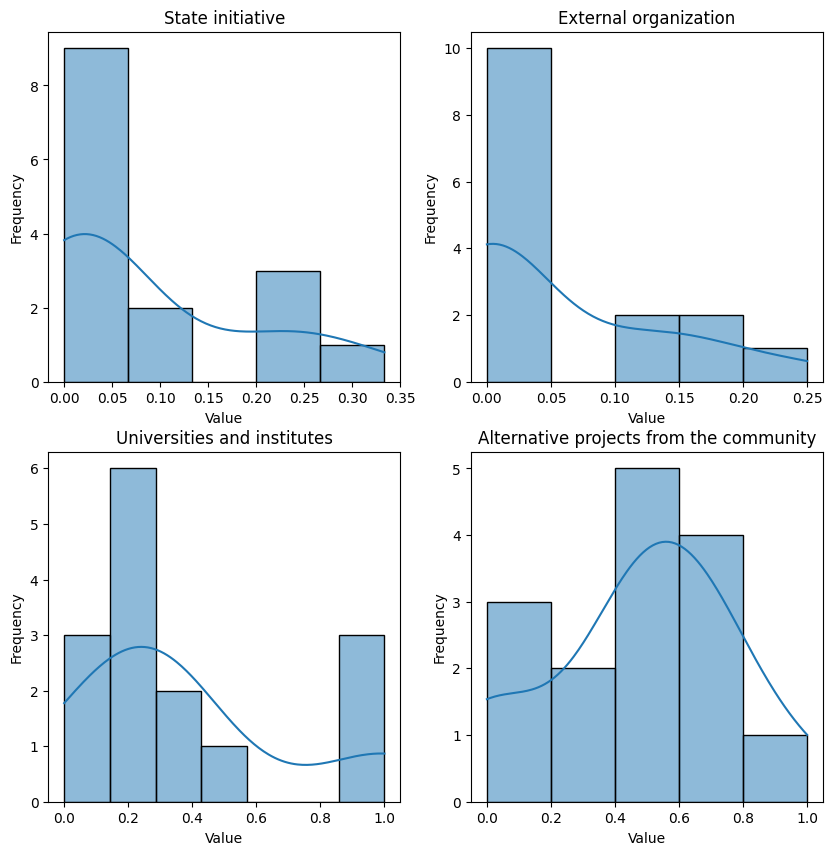

In [18]:
#Before doing an ANOVA, we need to check if each one of the groups has a normal distribution using the Shapiro-Wilk test and plot the distribution of each group
#in a 2x2 grid
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
for i, column in enumerate(df_prop_projects_year.columns):
    data = df_prop_projects_expanded[df_prop_projects_expanded['Origin'] == column]['Value']
    sns.histplot(data, kde=True, ax=axs[i])
    axs[i].set_title(column)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('Frequency')
    stat, p = shapiro(data)
    print('Shapiro-Wilk test for {}: stat={}, p={}'.format(column, stat, p))

As most of the groups are not normally distributed, we will use the Kruskal-Wallis test to compare the proportions of each origin by year.

In [24]:
#Test for homogeneity of variances using Levene's test
from scipy.stats import levene

stat, p = levene(df_prop_projects_expanded[df_prop_projects_expanded['Origin'] == 'State initiative']['Value'],
                    df_prop_projects_expanded[df_prop_projects_expanded['Origin'] == 'External organization']['Value'],
                    df_prop_projects_expanded[df_prop_projects_expanded['Origin'] == 'Alternative projects from the community']['Value'],
                    df_prop_projects_expanded[df_prop_projects_expanded['Origin'] == 'Universities and institutes']['Value'])
print('Levene test: stat={}, p={}'.format(stat, p))

Levene test: stat=3.864296343987006, p=0.013914908362763028


The evidence indicates that the variances are not equal, so we will need to consider that when interpreting the results.

In [25]:
from scipy.stats import kruskal

H = kruskal(df_prop_projects_expanded[df_prop_projects_expanded['Origin'] == 'State initiative']['Value'],
            df_prop_projects_expanded[df_prop_projects_expanded['Origin'] == 'External organization']['Value'],
            df_prop_projects_expanded[df_prop_projects_expanded['Origin'] == 'Alternative projects from the community']['Value'],
            df_prop_projects_expanded[df_prop_projects_expanded['Origin'] == 'Universities and institutes']['Value'])
print('Kruskal-Wallis test: H={}, p={}'.format(H.statistic, H.pvalue))

Kruskal-Wallis test: H=23.08028675904543, p=3.885643894116411e-05


The p-value is significant, so we can reject the null hypothesis that the proportions of each origin are the same for each year. That means that at least one group is stochastically different from the others.

In [26]:
from scikit_posthocs import posthoc_dunn

df_prop_projects_expanded['Origin'] = df_prop_projects_expanded['Origin'].astype('category')
posthoc = posthoc_dunn(df_prop_projects_expanded, val_col='Value', group_col='Origin', p_adjust='holm')
print(posthoc)


                                         Alternative projects from the community  \
Alternative projects from the community                                 1.000000   
External organization                                                   0.000414   
State initiative                                                        0.004022   
Universities and institutes                                             1.000000   

                                         External organization  \
Alternative projects from the community               0.000414   
External organization                                 1.000000   
State initiative                                      1.000000   
Universities and institutes                           0.004022   

                                         State initiative  \
Alternative projects from the community          0.004022   
External organization                            1.000000   
State initiative                                 1.000000   
Univ